In [40]:
#analyze results of nearest neighbor averaging of chi2s

from halotools.sim_manager import CachedHaloCatalog, FakeSim
from halotools.empirical_models import PrebuiltHodModelFactory, Zheng07Cens, Zheng07Sats, TrivialPhaseSpace, NFWPhaseSpace, HodModelFactory
from halotools.mock_observables import return_xyz_formatted_array,wp
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time
from multiprocessing import Pool, cpu_count
import emcee
import corner
from Corrfunc.theory.wp import wp
from numpy.linalg import inv
import scipy.optimize as op
from scipy.stats import chi2
import scipy.stats as stats
import random
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from scipy.special import gamma
from scipy.stats import chisquare, gaussian_kde,skewnorm,expon
from sklearn.neighbors import NearestNeighbors, KDTree
from tabcorr import TabCorr

In [78]:
fname = "zehavi_smdpl_mvir_m20_test.h5"
wp_out_file = None#'zehavi_smdpl_mvir_m19_wp.npy'
dname ='zehavi_data_file_20'
param = 'mvir'
threshold = 20
ext = 'mvir_m20.npz'

In [79]:
files = [fname]
#files = [fname4,fname5]
s = []
log_prob_s = []
wps = []
for f in files: 
    reader = emcee.backends.HDFBackend(f, read_only=True)
    s.append(reader.get_chain(discard=1000, flat=False, thin=1))
    log_prob_s.append(reader.get_log_prob(discard=1000, flat=False, thin=1))
    wps.append(reader.get_blobs(discard=1000))
print(reader.iteration)

100000


In [80]:
if len(files)>1:
    print('greater')
    samples = s[0]
    log_prob_samples = log_prob_s[0]
    wp_samples = wps[0]
    for i in range(len(files)):
        if i+1 < len(s):
            samples = np.concatenate((samples,s[i+1]))
            log_prob_samples = np.concatenate((log_prob_samples,log_prob_s[i+1]))
            wp_samples = np.concatenate((wp_samples,wps[i+1]))
else:
    samples = s[0]
    log_prob_samples = log_prob_s[0]
    wp_samples = wps[0]
min_chi2_loc = np.where(-2*log_prob_samples==(-2*log_prob_samples.max()))
#best_wp = wp_samples[min_chi2_loc][0]
best_chi2 = (-2*log_prob_samples[min_chi2_loc])[0]


In [81]:
dsamples = samples[:,:20,:][::50,:]
print(dsamples.shape)
dsamples=samples[:,:20,:][::50,:].reshape(dsamples.shape[0]*dsamples.shape[1],5)

(1980, 20, 5)


In [82]:
####Prepare data for nearest neighbor search
print('Median values:')
print(' logMvirmin, sigma_logMvir, alpha, logMvir_0, logMvir1')
params_median = np.median(dsamples, axis=0)
params_std = np.std(dsamples, axis=0)
print('  ', params_median[[0, 1, 2, 3, 4]])
print('+-', params_std[[0, 1, 2, 3, 4]])
print()

# Find the best-fit parameters in segments of the chain
params_1_sigma_range = (np.percentile(dsamples, 84, axis=0) - np.percentile(dsamples, 16, axis=0))/2

print('1-sigma range:')
print(' logMvirmin, sigma_logMvir, alpha, logMvir_0, logMvir1')
print('  ', params_1_sigma_range[[0, 1, 2, 3, 4]])

Median values:
 logMvirmin, sigma_logMvir, alpha, logMvir_0, logMvir1
   [11.91719003  0.2128374   1.13642631 11.70518097 13.27974316]
+- [0.04155684 0.13484987 0.04491162 0.70401493 0.04286046]

1-sigma range:
 logMvirmin, sigma_logMvir, alpha, logMvir_0, logMvir1
   [0.03395102 0.13684099 0.04404828 0.79163778 0.04087823]


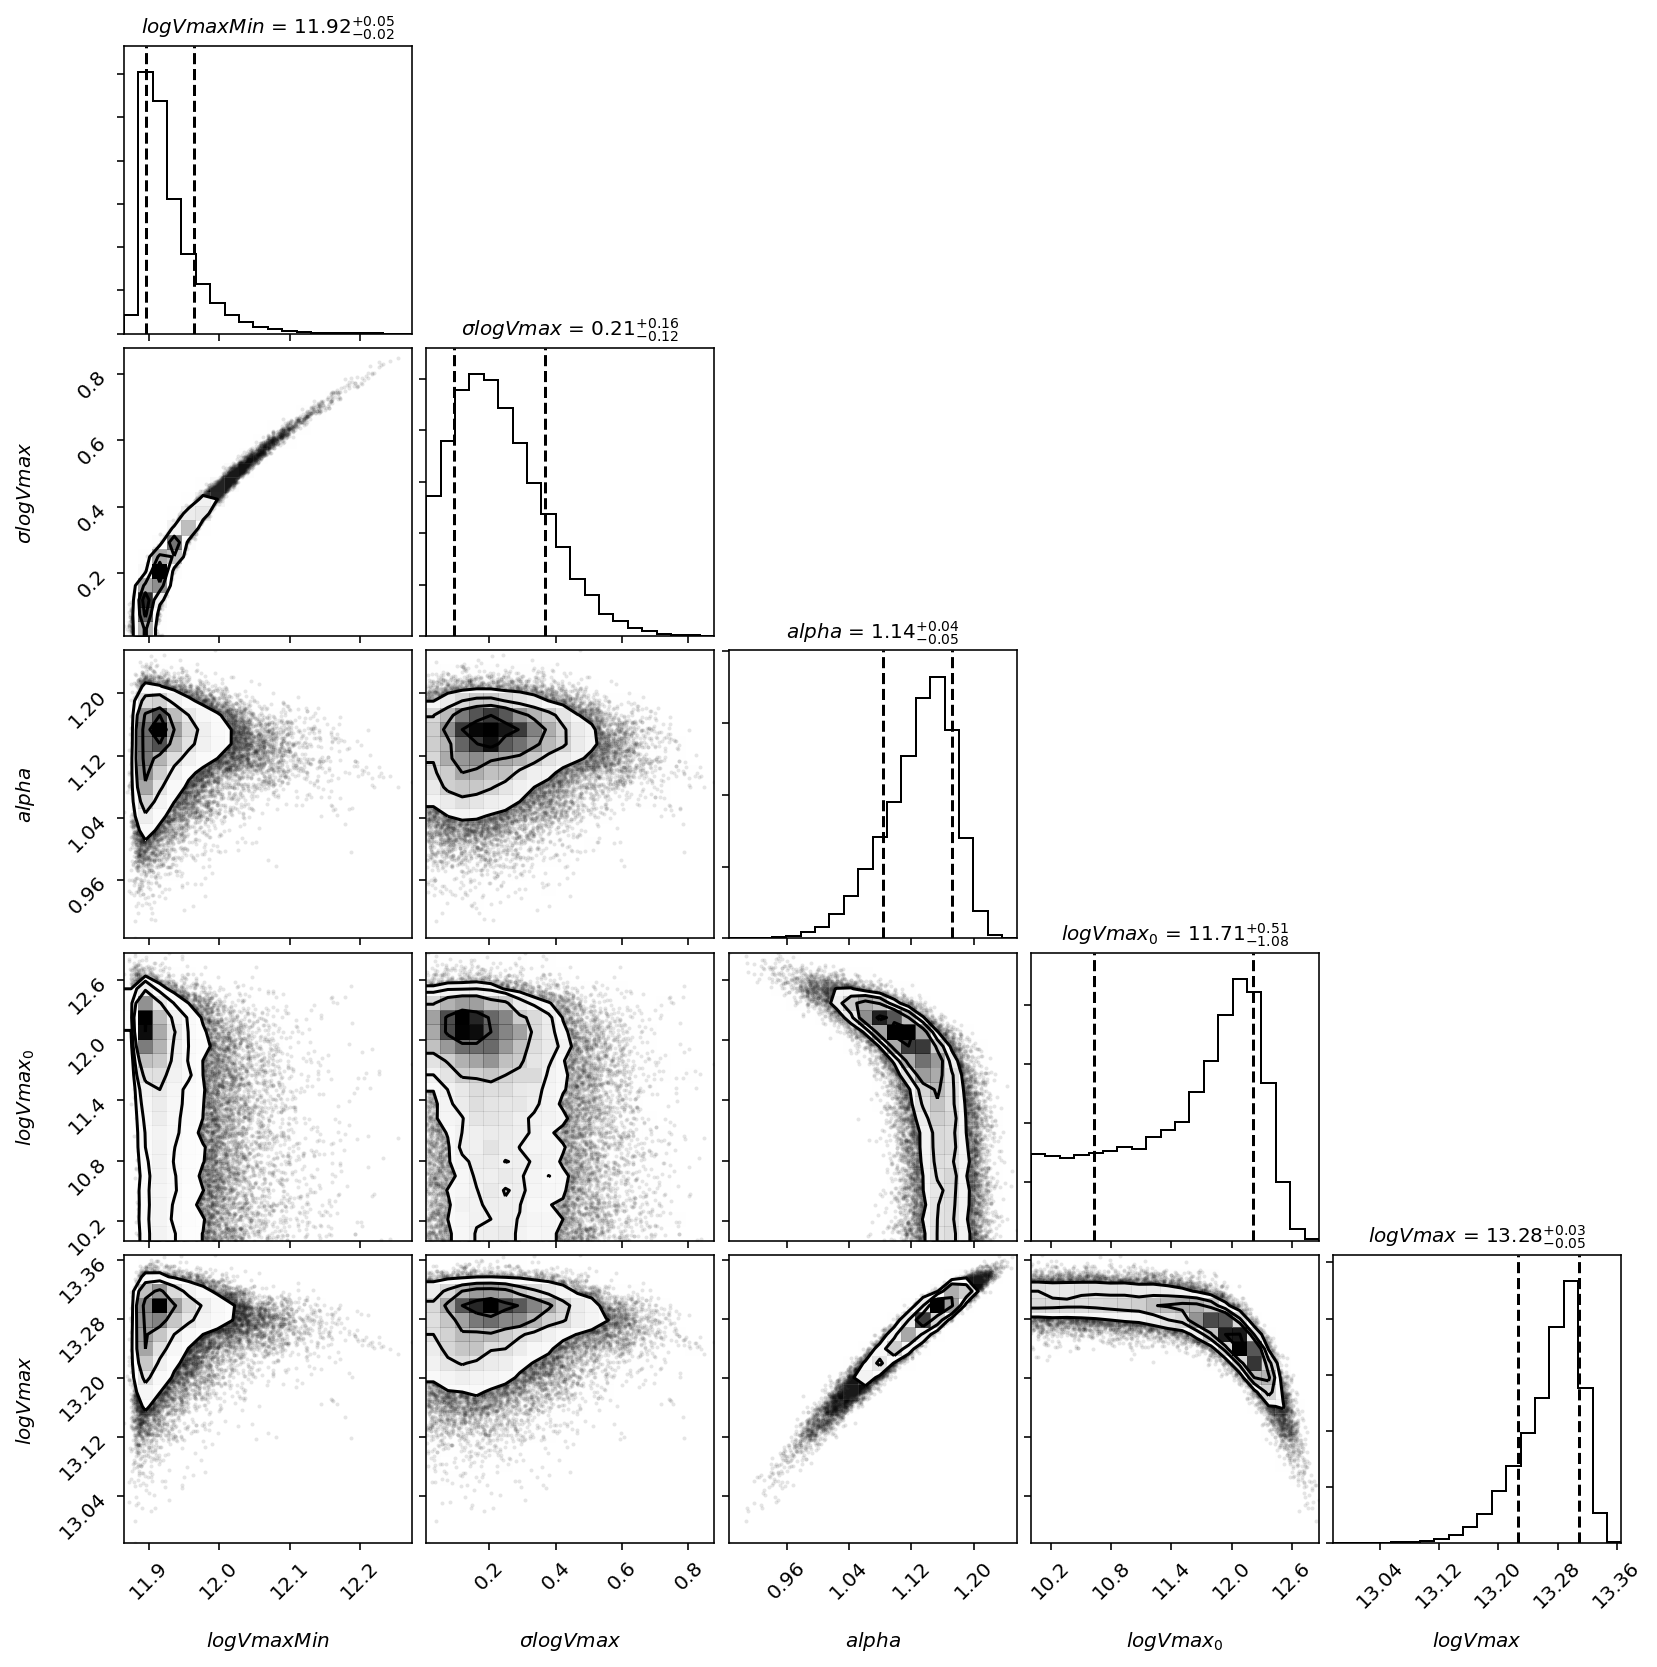

In [83]:
ndim=5
fig = corner.corner(dsamples.reshape((-1,ndim)),
        labels=["$logVmaxMin$", "${\sigma}logVmax$", "$alpha$", "$logVmax_0$", "$logVmax$"],
        show_titles=True,title_kwargs={"fontsize": 10},quantiles=(0.16, 0.84),bins=20)#, levels=(1-np.exp(-0.5),))

In [84]:
data = dsamples[:, :6]

# Reflect against hard prior boundaries
# sigma_logM

#data_new = np.copy(data)
#data_new[:, 1] = -data_new[:, 1]
#data = np.concatenate([data, data_new], axis=0)

#data_new = np.copy(data)
#data_new[:, 3] = -data_new[:, 3]
#data = np.concatenate([data, data_new], axis=0)

# rescaling the dimensions
data_rescale = data/params_1_sigma_range[None, :6]

# Find the distance to the n-th nearest neighbor
neigh = NearestNeighbors(n_neighbors=501, radius=np.inf, algorithm='kd_tree')
neigh.fit(data_rescale)
dist, _ = neigh.kneighbors(data_rescale, return_distance=True)

# Remove the reflected points
maxdist = np.max(dist, axis=1)
idx_best = np.argsort(maxdist)
mask = idx_best < len(dsamples)
print(np.sum(mask)/len(idx_best))
idx_best = idx_best[mask]

# select the top n_best points
n_best = 500
idx_best = idx_best[:n_best]
print(dsamples[idx_best][0])

1.0
[11.89852128  0.12433144  1.10342231 12.14734895 13.24360668]


In [85]:
if '21' in dname:
    import zehavi_data_file_21
    wp_ng_vals = zehavi_data_file_21.get_wp()[0:12]
    bin_edges = zehavi_data_file_21.get_bins()[0:12]
    cov_matrix = zehavi_data_file_21.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    invcov = inv(cov_matrix)
    ng_cov = 0.000005
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
if '19' in dname:
    print('19')
    import zehavi_data_file_19
    wp_ng_vals = zehavi_data_file_19.get_wp()[0:12]
    bin_edges = zehavi_data_file_19.get_bins()[0:12]
    cov_matrix = zehavi_data_file_19.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])    
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
    invcov = inv(cov_matrix)
    ng_cov = 0.000068
if '20' in dname:
    print('20')
    import zehavi_data_file_20
    wp_ng_vals = zehavi_data_file_20.get_wp()[0:12]
    bin_edges = zehavi_data_file_20.get_bins()[0:12]
    cov_matrix = zehavi_data_file_20.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])    
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
    invcov = inv(cov_matrix)
    ng_cov = 0.00007
if 'guo' in dname:
    wp_ng_vals = guo_data_file.get_wp()
    bin_edges = guo_data_file.get_bins()
    cov_matrix = guo_data_file.get_cov()
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.

if 'mock' in dname:
    wp_ng_vals = mock_data_2.get_wp()
    bin_edges = mock_data_2.get_bin_edges()
    cov_matrix = mock_data_2.get_cov()
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.

20


In [86]:
if param == 'mvir':
    print('mvir')
    cens_occ_model = Zheng07Cens(threshold=threshold)
    cens_prof_model = TrivialPhaseSpace()

    sats_occ_model =  Zheng07Sats(modulate_with_cenocc=True,threshold=threshold)
    sats_prof_model = NFWPhaseSpace()
    halotab = TabCorr.read('smdpl_mvir.hdf5')
else:
    print('vmax')
    cens_occ_model = Zheng07Cens(prim_haloprop_key = 'halo_vmax',threshold=threshold)
    cens_prof_model = TrivialPhaseSpace()

    sats_occ_model =  Zheng07Sats(prim_haloprop_key = 'halo_vmax', modulate_with_cenocc=True,threshold=threshold)
    sats_prof_model = NFWPhaseSpace()
    halotab = TabCorr.read('smdpl_vmax.hdf5')
    
#halocat = CachedHaloCatalog(simname='bolshoi',redshift = 0.0)
#halocat = CachedHaloCatalog(fname = '/Users/lmezini/.astropy/cache/halotools/halo_catalogs/bolplanck/rockstar/hlist_1.00231.list.halotools_v0p4.hdf5',update_cached_fname = True)
#halocat = CachedHaloCatalog(fname = '/Users/lmezini/Downloads/hlist_1.00231.list.halotools_v0p1.hdf5',update_cached_fname = True)
halocat = CachedHaloCatalog(fname='/Users/lmezini/.astropy/cache/halotools/halo_catalogs/SMDPL/rockstar/2019-07-03-18-38-02-9731.dat.my_cosmosim_halos.hdf5')
halocat.redshift = 0.
pi_max = 60.
Lbox = 400.
model_instance = HodModelFactory(centrals_occupation = cens_occ_model, centrals_profile = cens_prof_model, 
                                 satellites_occupation = sats_occ_model, satellites_profile = sats_prof_model)


mvir


Best-fit values from top 500:
  [logMvirmin, sigma_logMvir, alpha, logMvir_0, logMvir1]
   [11.90098742  0.13626748  1.09627215 12.12796982 13.2412772 ]
 + [0.06337363 0.23225784 0.07538859 0.0829029  0.06751957]
 - [0.00452841 0.04142413 0.01270797 1.50037266 0.0142369 ]


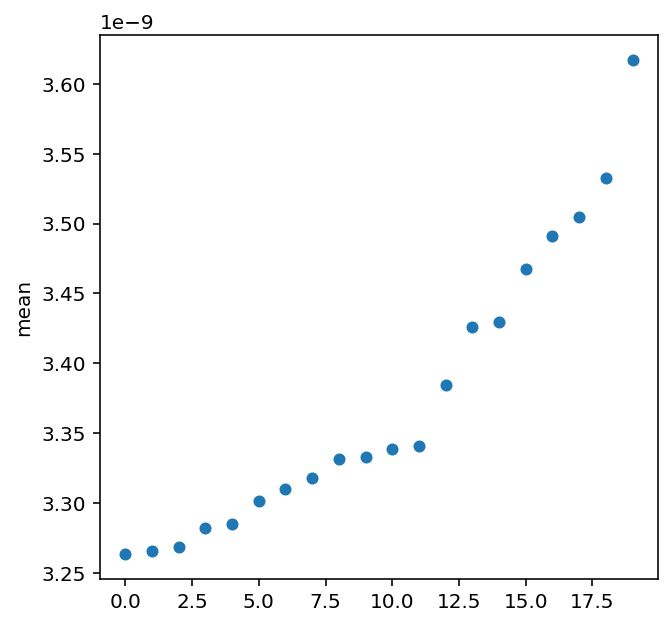

In [87]:
results = np.load('best_fit_lnprob_'+ext)#_vmax_m21_2.npz')
like_all = results['lnlike_all']
nrepeat=100

like_mean = np.mean(like_all,axis=1)

idx_best_10 = idx_best[np.argsort(like_mean)[-10:]]
params_best = dsamples[idx_best_10[0]]
params_best_plus = np.percentile(dsamples, 84, axis=0) - params_best
params_best_minus = params_best - np.percentile(dsamples, 16, axis=0)
print('Best-fit values from top 500:')
print('  [logMvirmin, sigma_logMvir, alpha, logMvir_0, logMvir1]')
print('  ', params_best[[0, 1, 2, 3, 4]])
print(' +', params_best_plus[[0, 1, 2, 3, 4]])
print(' -', params_best_minus[[0, 1, 2, 3, 4]])

plt.figure(figsize=(5, 5))
plt.errorbar(np.arange(20), like_mean[np.argsort(np.mean(like_all,axis=1))[-20:]], 
             yerr=np.std(like_all[np.argsort(np.mean(like_all,axis=1))[-20:]], axis=1)/np.sqrt(nrepeat), 
             markersize=10, fmt='x', marker='.')
plt.ylabel('mean')
plt.show()

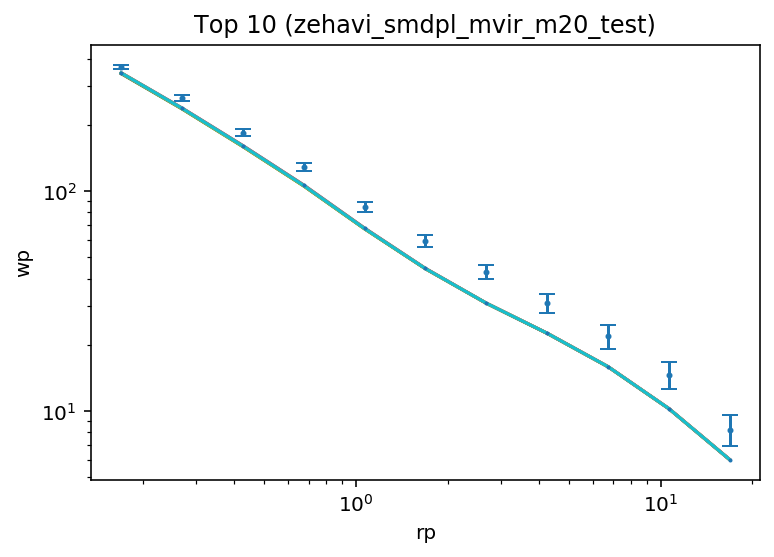

In [88]:
plt.errorbar(bin_cen,wp_ng_vals[1:len(wp_ng_vals)],yerr=np.sqrt(err),fmt='o',markersize=2,capsize=4,label='data')
for p in dsamples[idx_best_10]:
    model_instance.param_dict['logMmin'] = p[0]#Mmin_val[i]
    model_instance.param_dict['sigma_logM'] = p[1]#sigma_val[i]
    model_instance.param_dict['alpha'] = p[2]#alpha_val[i]
    model_instance.param_dict['logM0'] = p[3]#M0_val[i]
    model_instance.param_dict['logM1'] = p[4]#M1_val[i]
   
    ngal, wp = halotab.predict(model_instance)
    plt.loglog(bin_cen, wp,markersize=1)
    plt.title('Top 10 ({})'.format(str(fname[:-3])))
    plt.xlabel('rp')
    plt.ylabel('wp')
plt.savefig('wp_plot_'+fname[:-3]+'.png')

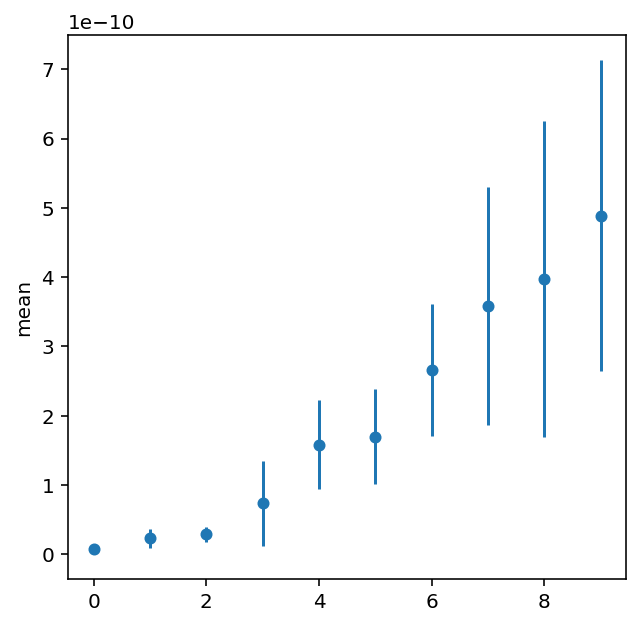

In [89]:
results = np.load('top10_best_fit_lnprob_'+ext)#vmax_m21_2.npz')#.format(zbin_index))
like_all = results['lnlike_all']

like_mean = np.mean(like_all, axis=1)
#print(np.argsort(lnlike_hlmean)[-1])
#print(np.argsort(lnlike_mean)[-1])
#print()
idx_single_best = idx_best_10[np.argsort(like_mean)[-1]]
#print(idx_single_best)

plt.figure(figsize=(5, 5))
plt.errorbar(np.arange(len(like_mean)), like_mean[np.argsort(like_mean)], 
             yerr=np.std(like_all[np.argsort(like_mean)], axis=1)/np.sqrt(nrepeat), 
             markersize=10, fmt='x', marker='.')
# plt.xlabel('mean')
plt.ylabel('mean')
plt.show()

In [90]:
idx_single_best = idx_best_10[np.argsort(like_mean)[-1]]
params_best = np.round(dsamples[idx_single_best],3)
params_best_plus = np.round(np.percentile(dsamples, 84, axis=0) - params_best,3)
params_best_minus = abs(np.round(params_best - np.percentile(dsamples, 16, axis=0),3))
print('Best-fit values from top 10:')
print('  [logMvirmin, sigma_logMvir, alpha, logMvir_0, logMvir1]')
print('  ', params_best[[0, 1, 2, 3, 4]])
print(' +', params_best_plus[[0, 1, 2, 3, 4]])
print(' -', params_best_minus[[0, 1, 2, 3, 4]])

Best-fit values from top 10:
  [logMvirmin, sigma_logMvir, alpha, logMvir_0, logMvir1]
   [11.897  0.12   1.1   12.15  13.24 ]
 + [0.067 0.249 0.072 0.061 0.069]
 - [1.000e-03 2.500e-02 1.600e-02 1.522e+00 1.300e-02]


In [91]:
results = np.load('single_best_results_'+ext)
like_all = results['lnlike_all']

mean = np.round(np.log(np.mean(like_all)),4)
chi2 = np.round(np.log(np.mean(like_all))*-2/7.,4)
print('mean likelihood from single best: {}'.format(mean))
print('chi2/dof: {}'.format(chi2))


mean likelihood from single best: -25.0592
chi2/dof: 7.1598


# Create Table

In [15]:
thresholds = [19,20,21]
i=2

In [16]:
#table_data = np.zeros([3,17])
table_data[i]+=np.array([thresholds[i],params_best[0],params_best_plus[0],params_best_minus[0],
                         params_best[1],params_best_plus[1],params_best_minus[1],
                         params_best[2],params_best_plus[2],params_best_minus[2],
                         params_best[3],params_best_plus[3],params_best_minus[3],
                         params_best[4],params_best_plus[4],params_best_minus[4],
                         chi2])

NameError: name 'table_data' is not defined

In [381]:
df = pd.DataFrame(data=table_data, columns=["threshold","logMmin","logMmin_plus","logMmin_minus","alpha","alpha_plus",
                                            "alpha_minus","sigma","sigma_plus","sigma_minus","logM0","logM0_plus",
                                            "logM0_minus","logM1","logM1_plus","logM1_minus","chi2"])

In [387]:
logMmin_err = []
alpha_err = []
sigma_err = []
logM0_err = []
logM1_err = []
for i in range(3):
    logMmin_err.append(str(df['logMmin'][i])+" ± ("+str(df['logMmin_plus'][i])+","+str(df['logMmin_minus'][i])+")")
    alpha_err.append(str(df['alpha'][i])+" ± ("+str(df['alpha_plus'][i])+","+str(df['alpha_minus'][i])+")")
    sigma_err.append(str(df['sigma'][i])+" ± ("+str(df['sigma_plus'][i])+","+str(df['sigma_minus'][i])+")")
    logM0_err.append(str(df['logM0'][i])+" ± ("+str(df['logM0_plus'][i])+","+str(df['logM0_minus'][i])+")")
    logM1_err.append(str(df['logM1'][i])+" ± ("+str(df['logM1_plus'][i])+","+str(df['logM1_minus'][i])+")")
df['logMmin_err']=logMmin_err
df['alpha_err']=alpha_err
df['sigma_err']=sigma_err
df['logM0_err']=logM0_err
df['logM1_err']=logM1_err

In [388]:
print(df.to_latex(index=False,columns = ['threshold','logMmin_err','alpha_err','sigma_err','logM0_err','logM1_err','chi2']))

\begin{tabular}{rlllllr}
\toprule
 threshold &            logMmin\_err &              alpha\_err &              sigma\_err &              logM0\_err &              logM1\_err &    chi2 \\
\midrule
       0.0 &        0.0 ± (0.0,0.0) &        0.0 ± (0.0,0.0) &        0.0 ± (0.0,0.0) &        0.0 ± (0.0,0.0) &        0.0 ± (0.0,0.0) &  0.0000 \\
      20.0 &  2.214 ± (0.409,0.002) &   0.03 ± (0.691,0.009) &  2.431 ± (0.636,0.241) &  2.257 ± (0.085,0.934) &  2.404 ± (0.174,0.099) &  0.6152 \\
      21.0 &  2.461 ± (0.031,0.006) &  0.079 ± (0.078,0.026) &  2.174 ± (0.861,0.462) &  2.525 ± (0.094,0.349) &  2.579 ± (0.196,0.136) &  0.4376 \\
\bottomrule
\end{tabular}

